In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
dataset = pd.read_csv('processed_train.csv')

In [18]:
dataset.shape

(550068, 10)

In [4]:
X=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [7]:
def min_max_scale(X_train,X_test):
    X_train_scale = MinMaxScaler()
    X_test_scale = MinMaxScaler()
    return X_train_scale.fit_transform(X_train), X_test_scale.fit_transform(X_test)

In [8]:
def std_scale(X_train,X_test):
    X_train_scale = StandardScaler()
    X_test_scale = StandardScaler()
    return X_train_scale.fit_transform(X_train), X_test_scale.fit_transform(X_test)

In [72]:
def poly_feat(X_train,X_test,degree=3):
    X_train_poly = PolynomialFeatures(degree=degree)
    X_test_poly = PolynomialFeatures(degree=degree)
    return X_train_poly.fit_transform(X_train),X_test_poly.fit_transform(X_test)

In [19]:
X_train_std_scale,X_test_std_scale = std_scale(X_train,X_test)
X_train_minmax_scale,X_test_minmax_scale = std_scale(X_train,X_test)

In [73]:
X_train_std_poly,X_test_std_poly = poly_feat(X_train_std_scale,X_test_std_scale)

In [74]:
X_train_minmax_poly,X_test_minmax_poly = poly_feat(X_train_minmax_scale,X_test_minmax_scale)

# Polynomial regression

In [75]:
lm_model = LinearRegression()

In [76]:
lm_model.fit(X_train_std_poly,y_train)

LinearRegression()

In [77]:
predictions=lm_model.predict(X_test_std_poly)

In [78]:
mae = mean_absolute_error(y_test,predictions)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)

In [79]:
print ('mean absolute error {}'.format(mae))
print('mena squared error {}'.format(mse))
print('root mean squared error {}'.format(rmse))

mean absolute error 4461690647559.419
mena squared error 3.2544413740026983e+25
root mean squared error 5704771138269.0


In [80]:
mae_mean = mean_absolute_error(y_test,target_mean_difference)
mse_mean = mean_squared_error(y_test,target_mean_difference)
rmse_mean = np.sqrt(mse_mean)

In [81]:
print ('mean absolute error {}'.format(mae_mean))
print('mena squared error {}'.format(mse_mean))
print('root mean squared error {}'.format(rmse_mean))

mean absolute error 4074.962178566068
mena squared error 25252052.826365035
root mean squared error 5025.142070266774


In [82]:
lm_model.fit(X_train_minmax_poly,y_train)

LinearRegression()

In [83]:
predictions=lm_model.predict(X_test_minmax_poly)

In [84]:
mae = mean_absolute_error(y_test,predictions)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)

In [85]:
print ('mean absolute error {}'.format(mae))
print('mena squared error {}'.format(mse))
print('root mean squared error {}'.format(rmse))

mean absolute error 4461690647559.419
mena squared error 3.2544413740026983e+25
root mean squared error 5704771138269.0


# Important Features

In [28]:
from sklearn.ensemble import ExtraTreesRegressor
extraTreesRegressor=ExtraTreesRegressor()

In [29]:
extraTreesRegressor.fit(X_train,y_train)

ExtraTreesRegressor()

In [30]:
feature_importances = pd.Series(extraTreesRegressor.feature_importances_,index=X_train.columns)

In [31]:
important_features=[]
for feature in X_train.columns:
    if feature_importances[feature] > 0.005:
        important_features.append(feature)
        
len(important_features)

9

In [32]:
important_features

['Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'Product_Category_2',
 'Product_Category_3']

# PCA

In [17]:
from sklearn.decomposition import PCA

In [25]:
campaign_pca = PCA(n_components=9)
campaign_pca.fit(X_train_minmax_scale)
variance = campaign_pca.explained_variance_ratio_

In [26]:
campaign_pca.explained_variance_ratio_

array([0.15878152, 0.12572337, 0.12384296, 0.11119354, 0.10851685,
       0.10745727, 0.10128804, 0.09510268, 0.06809378])

In [23]:
import matplotlib.pyplot as plt

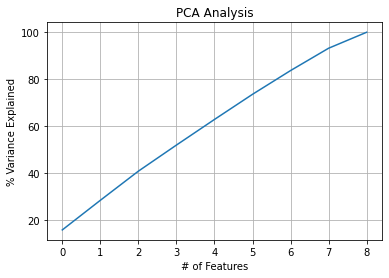

In [27]:
var = np.cumsum(np.round(variance,3)*100)
plt.grid()
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
#plt.ylim(0,100.5)

plt.plot(var)

In [33]:
n_estimators=[int(x) for x in np.linspace(start=100,stop=1000,num=12)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(5,30,num=6)]
min_samples_split=[10,50,100]
min_samples_leaf=[5,10]

random_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}

In [34]:
rmscv_model = RandomizedSearchCV(
            RandomForestRegressor(),
            param_distributions=random_grid,
            scoring='neg_mean_squared_error',
            n_iter=10,
            cv=5,
            random_state=0
        )

In [36]:
rmscv_model.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [10, 50, 100],
                                        'n_estimators': [100, 181, 263, 345,
                                                         427, 509, 590, 672,
                                                         754, 836, 918, 1000]},
                   random_state=0, scoring='neg_mean_squared_error')

In [37]:
import pickle
file=open('rmscv_model.pkl','wb')
pickle.dump(rmscv_model,file)

In [39]:
rmscv_model.best_params_

{'n_estimators': 427,
 'min_samples_split': 100,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 15}

In [40]:
rf_model = RandomForestRegressor(n_estimators= 427,
 min_samples_split= 100,
 min_samples_leaf= 5,
 max_features = 'auto',
 max_depth= 15)

In [41]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=100,
                      n_estimators=427)

In [48]:
predictions = rf_model.predict(X_test)

In [49]:
mae = mean_absolute_error(y_test,predictions)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)

In [52]:
print ('mean absolute error {}'.format(mae))
print('mena squared error {}'.format(mse))
print('root mean squared error {}'.format(rmse))

mean absolute error 2170.5875937538876
mena squared error 8410242.931837019
root mean squared error 2900.0418844970186


In [53]:
target_mean_difference = pd.Series(np.mean(y_test),index= y_test.index)

In [55]:
mae_mean = mean_absolute_error(y_test,target_mean_difference)
mse_mean = mean_squared_error(y_test,target_mean_difference)
rmse_mean = np.sqrt(mse_mean)

In [57]:
print ('mean absolute error {}'.format(mae_mean))
print('mena squared error {}'.format(mse_mean))
print('root mean squared error {}'.format(rmse_mean))

mean absolute error 4074.962178566068
mena squared error 25252052.826365035
root mean squared error 5025.142070266774


In [58]:
file=open('rf_model.pkl','wb')
pickle.dump(rf_model,file)